We are interested in the following quantity
$$
p(T, x, y) = \mathbb{P}_x(X_t \in \Omega \text{ for all } t \le T | X_T=y),
$$
where $\Omega \subset \mathbb{R}^d$.
Such term can be approximated by
$p(T, x, y) \approx \frac{\mathbb{P}_x(X_T \in A \ \text{ and } \ X_t \in \Omega \text{ for all } t \le T)}{\mathbb{P}_x(X_T \in A)} = \frac{u_A(0, x)}{\mathbb{P}_x(X_T \in A)}$,
where $A$ is a small neighborhood containing $y$
and $u_A$ satisfies the following PDE:
\begin{align*}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega.
\end{align*}

For simplicity, we first deal with the case $\nu=1$, $d=1$, $\Omega = (\infty, 2]$, $x = 0$, $y = 1$, $A = [1 - \epsilon, 1 + \epsilon]$.

In this case, $p(T, x, y)$ is known explicitly as
$$
p(T, x, y) = 1 - \exp\left(\frac{(y - x)^2 - (4-x-y))^2}{2\nu T}\right).
$$

In [1]:
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from galerkin import DGMNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
eps = 1e-1
a, b = 1 - eps, 1 + eps

# function definition
deriv_map = np.array([2]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return .5 * y[0]

def phi_example(x):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

from scipy.stats import norm
def exact_example(t, x, T):
    if t == T:
        return np.zeros_like(x[0])
        # return np.logical_and(x[0] <= b, x[0] >= a).astype(float)
    else:
        return (norm.cdf(b - x[0]) - norm.cdf(a - x[0]))
#         return norm.cdf((b - x[0])/math.sqrt(T-t)) - norm.cdf((a - x[0])/math.sqrt(T-t))

t_lo, x_lo, x_hi, n = 0., -8., 8., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

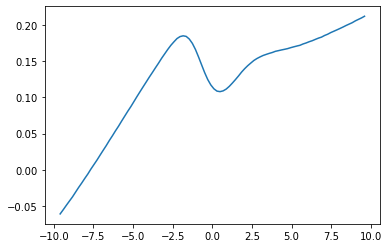

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [3]:
model = DGMNet(
    dgm_nb_states=10000,
    dgm_f_fun=f_example,
    dgm_deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    epochs=10000,
    dgm_lr=1e-4,
)
model.train_and_eval(debug_mode=True)

nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device))
    .detach()
    .cpu()
    .numpy()
)
plt.plot(grid, nn, label="NN approximation for terminal condition")
plt.plot(grid, (norm.cdf(1 + eps - grid) - norm.cdf(1 - eps - grid)), label="Terminal condition")

# Not working....

In [33]:
indicator_smooth = lambda x, degree=10000: torch.nn.Sigmoid()(degree * x)

class Net(torch.nn.Module):
    def __init__(
        self,
        neurons=20,
        layers=5,
        lr=1e-3,
        lr_milestones=[1000, 2000],
        lr_gamma=0.1,
        epochs=10000,
        batch_normalization=True,
        device="cpu",
        eps=1e-1,
        nu=1,
        nb_states=10000,
        t_lo=0, 
        t_hi=1,
        x_lo=-1, 
        x_hi=2,
        weight_decay=0.,
        verbose=True,
        **kwargs,
    ):
        super(Net, self).__init__()
        self.dim = 1
        self.u_layer = torch.nn.ModuleList(
            [torch.nn.Linear(self.dim + 1, neurons, device=device)]
            + [torch.nn.Linear(neurons, neurons, device=device) for _ in range(layers)]
            + [torch.nn.Linear(neurons, 1, device=device)]
        )
        self.u_bn_layer = torch.nn.ModuleList(
            [torch.nn.BatchNorm1d(self.dim + 1, device=device)]
            + [torch.nn.BatchNorm1d(neurons, device=device) for _ in range(layers + 1)]
        )
        self.activation = torch.nn.Tanh()
        self.loss = torch.nn.MSELoss()

        self.lr = lr
        self.lr_milestones = lr_milestones
        self.lr_gamma = lr_gamma
        self.epochs = epochs
        self.batch_normalization = batch_normalization
        self.device = device
        self.eps = eps
        self.nu = nu
        self.nb_states = nb_states
        self.t_lo, self.t_hi = t_lo, t_hi
        self.x_lo, self.x_hi = x_lo, x_hi
        self.weight_decay = weight_decay
        self.verbose = verbose

    def forward(self, x):
        layer = self.u_layer
        bn_layer = self.u_bn_layer

        y = x
        if self.batch_normalization:
            y = bn_layer[0](y)
        for idx, (f, bn) in enumerate(zip(layer[:-1], bn_layer[1:])):
            tmp = f(y)
            tmp = self.activation(tmp)
            if self.batch_normalization:
                tmp = bn(tmp)
            if idx == 0:
                y = tmp
            else:
                # resnet
                y = tmp + y

        y = layer[-1](y).squeeze(dim=-1)
        return y
#         return torch.nn.Sigmoid()(y)
    
    @staticmethod
    def nth_derivatives(order, y, x):
        """
        calculate the derivatives of y wrt x with order `order`
        """
        for cur_dim, cur_order in enumerate(order):
            for _ in range(int(cur_order)):
                try:
                    grads = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
                except RuntimeError:
                    # when very high order derivatives are taken for polynomial function
                    # it has 0 gradient but torch has difficulty knowing that
                    # hence we handle such error separately
                    return torch.zeros_like(y)

                # update y
                y = grads[cur_dim]
        return y
    
    def p(self, T, x, y):
        return (norm.cdf(y + self.eps - x) - norm.cdf(y - self.eps - x))
#         return 1 - np.exp(((y - x)**2 - (4 - x - y)**2)/(2*self.nu*T))
    
    def pp(self, T, x):
        return norm.cdf((3 + self.eps))

    def pde_loss(self, x):
        """"
        calculate the PDE loss partial_t u + f
        """
        x = x.detach().clone().requires_grad_(True)
        dt = self.nth_derivatives((1, 0), self(x.T), x)
        dxx = self.nth_derivatives((0, 2), self(x.T), x)
        return self.loss(dt + .5 * self.nu * dxx, torch.zeros_like(dt))

    def gen_sample(self):
        """
        generate (uniform) sample based on the (t_lo, t_hi) x (x_lo, x_hi)
        """
        # sample for intermediate value
        unif = torch.rand(self.nb_states, device=self.device)
        t = self.t_lo + (self.t_hi - self.t_lo) * unif
        unif = torch.rand(self.nb_states * self.dim, device=self.device).reshape(
            self.dim, -1
        )
        x = self.x_lo + (self.x_hi - self.x_lo) * unif
        tx = torch.cat((t.unsqueeze(0), x), dim=0)
        
        # sample for initial time
        t = self.t_lo * torch.ones(self.nb_states, device=self.device)
        unif = torch.rand(self.nb_states * self.dim, device=self.device).reshape(
            self.dim, -1
        )
        x = self.x_lo + (self.x_hi - self.x_lo) * unif
        tx_init = torch.cat((t.unsqueeze(0), x), dim=0)

        # sample for boundary value
        unif = torch.rand(self.nb_states, device=self.device)
        t = self.t_lo + (self.t_hi - self.t_lo) * unif
        unif = torch.rand(self.nb_states * self.dim, device=self.device).reshape(
            self.dim, -1
        )
        x = self.x_hi + (self.x_hi - self.x_hi) * unif
        tx_bound = torch.cat((t.unsqueeze(0), x), dim=0)

        # sample for terminal time
        t = self.t_hi * torch.ones(self.nb_states, device=self.device)
        unif = torch.rand(self.nb_states * self.dim, device=self.device).reshape(
            self.dim, -1
        )
        x = self.x_lo + (self.x_hi - self.x_lo) * unif
        tx_term = torch.cat((t.unsqueeze(0), x), dim=0)
        
        # sample for terminal time for small interval
        t = self.t_hi * torch.ones(self.nb_states, device=self.device)
        unif = torch.rand(self.nb_states * self.dim, device=self.device).reshape(
            self.dim, -1
        )
        x = 1 - self.eps + 2 * self.eps * unif
        tx_term = torch.cat([tx_term, torch.cat((t.unsqueeze(0), x), dim=0)], dim=-1)        

        return tx, tx_bound, tx_term, tx_init
    
    def train_and_eval(self, debug_mode=True):
        # initialize optimizer
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=self.lr_milestones,
            gamma=self.lr_gamma,
        )
        
        start = time.time()
        # loop through epochs
        for epoch in range(self.epochs):
            if epoch % self.epochs == 0:
                tx, tx_bound, tx_term, tx_init = self.gen_sample()

            # to calculate BN correctly
            self.train()
            _ = self(tx.T)
            self.eval()

            # clear gradients and evaluate training loss
            optimizer.zero_grad()

            # terminal loss + boundary loss + pde loss
            loss = self.loss(
                self(tx_term.T), 
                indicator_smooth((tx_term[1]-1+self.eps)) * indicator_smooth((1+self.eps-tx_term[1])),
            )
#             loss += self.loss(self(tx_bound.T), torch.zeros_like(tx_bound[1]))
            loss += self.pde_loss(tx)
#             loss += self.pde_loss(tx_term)
#             loss += self.pde_loss(tx_init)

            # update model weights
            loss.backward()
            optimizer.step()
            scheduler.step()

            # print loss information every 500 epochs
            if epoch % 500 == 0 or epoch + 1 == self.epochs:
                if debug_mode:
                    grid = np.linspace(self.x_lo, self.x_hi, 100).astype(np.float32)
                    grid_nd = np.concatenate(
                        (
                            self.t_lo * np.ones((1, 100)),
                            np.expand_dims(grid, axis=0),
                        ),
                        axis=0,
                    ).astype(np.float32)
                    nn = (
                        self(torch.tensor(grid_nd.T, device=self.device))
                        .detach()
                        .cpu()
                        .numpy()
                    )
#                     nn /= (norm.cdf(1 + self.eps - grid) - norm.cdf(1 - self.eps - grid))
                    plt.plot(grid, nn, label="NN approximation")
#                     plt.plot(grid, torch.ones_like(torch.tensor(grid)), label="Exact solution")
                    plt.plot(grid, self.p(1, grid, 1), label="Exact solution")
                    plt.legend()
                    plt.show()
                if self.verbose:
                    print(f"Epoch {epoch} with loss {loss.detach()}")
        if self.verbose:
            print(
                f"Training of neural network with {self.epochs} epochs take {time.time() - start} seconds."
            )

tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.9605e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5238, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


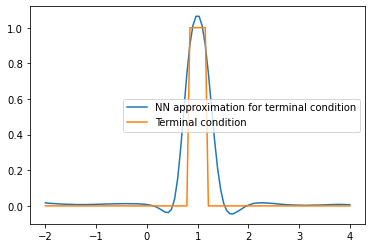

In [7]:
# check which loss is higher
tx, tx_bound, tx_term, tx_init = model.gen_sample()
print(model.loss(model(tx_term.T), indicator_smooth((tx_term[1]-1+model.eps)) * indicator_smooth((1+model.eps-tx_term[1]))))
print(model.loss(model(tx_bound.T), torch.zeros_like(tx_bound[1])))
print(model.pde_loss(tx))
print(model.pde_loss(tx_term))
print(model.pde_loss(tx_init))

# check NN approximation for terminal condition
grid = np.linspace(model.x_lo, model.x_hi, 100).astype(np.float32)
grid_nd = np.concatenate(
    (
        model.t_hi * np.ones((1, 100)),
        np.expand_dims(grid, axis=0),
    ),
    axis=0,
).astype(np.float32)
nn = (
    model(torch.tensor(grid_nd.T, device=model.device))
    .detach()
    .cpu()
    .numpy()
)
plt.plot(grid, nn, label="NN approximation for terminal condition")
plt.plot(grid, indicator_smooth(torch.tensor(grid-1+model.eps)) * indicator_smooth(torch.tensor(1+model.eps-grid)), label="Terminal condition")
plt.legend()
plt.show()

In [ ]:
# check which loss is higher
tx, tx_bound, tx_term, tx_init = model.gen_sample()
print(model.loss(model(tx_term.T), indicator_smooth((tx_term[1]-1+model.eps)) * indicator_smooth((1+model.eps-tx_term[1]))))
print(model.loss(model(tx_bound.T), torch.zeros_like(tx_bound[1])))
print(model.pde_loss(tx))
print(model.pde_loss(tx_term))
print(model.pde_loss(tx_init))

# check NN approximation for terminal condition
grid = np.linspace(model.x_lo, model.x_hi, 100).astype(np.float32)
grid_nd = np.concatenate(
    (
        model.t_lo * np.ones((1, 100)),
        np.expand_dims(grid, axis=0),
    ),
    axis=0,
).astype(np.float32)
nn = (
    model(torch.tensor(grid_nd.T, device=model.device))
    .detach()
    .cpu()
    .numpy()
)
plt.plot(grid, nn, label="NN approximation for terminal condition")
plt.plot(grid, (norm.cdf(1 + eps - grid) - norm.cdf(1 - eps - grid)), label="Terminal condition")
plt.legend()
plt.show()

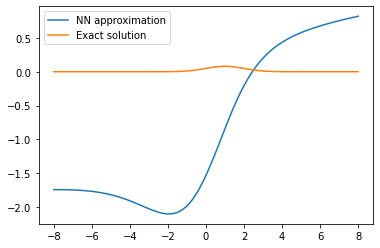

Epoch 0 with loss 2.334458351135254


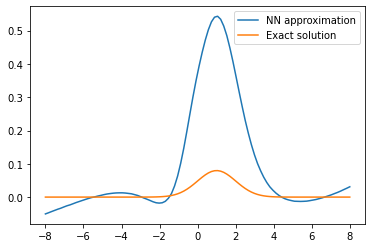

Epoch 500 with loss 0.04021236672997475


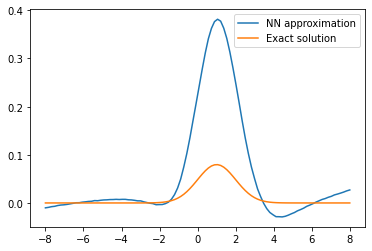

Epoch 1000 with loss 0.023623617365956306


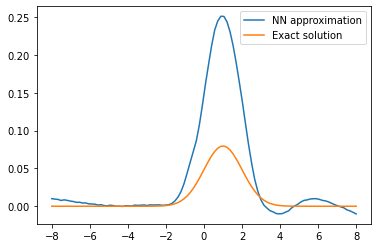

Epoch 1500 with loss 0.01277506910264492


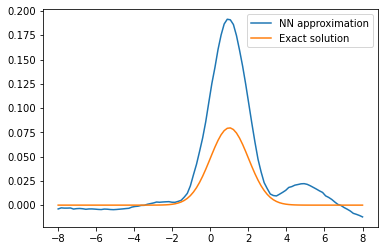

Epoch 2000 with loss 0.008022047579288483


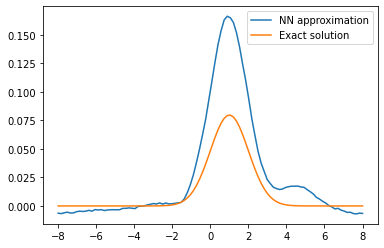

Epoch 2500 with loss 0.006470940075814724


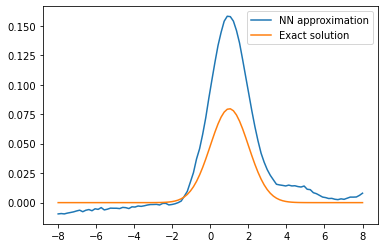

Epoch 3000 with loss 0.006053468678146601


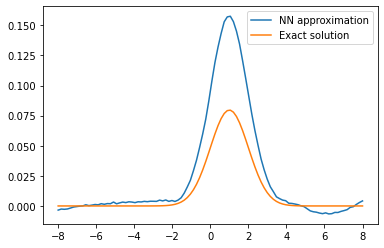

Epoch 3500 with loss 0.005672728177160025


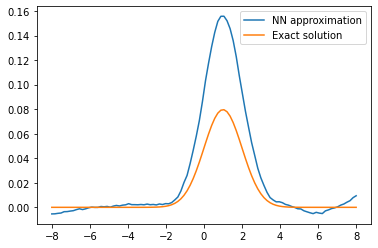

Epoch 4000 with loss 0.0052954633720219135


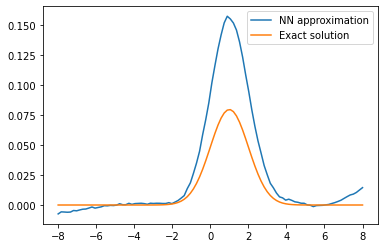

Epoch 4500 with loss 0.004994586110115051


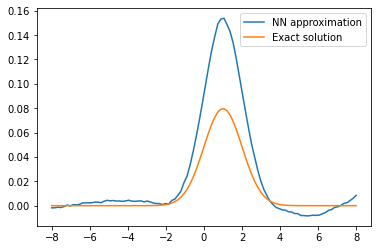

Epoch 5000 with loss 0.004606479778885841


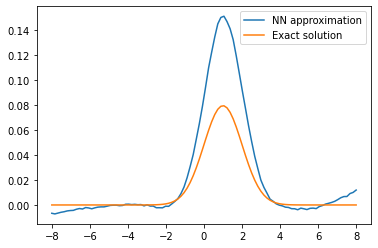

Epoch 5500 with loss 0.004188245162367821


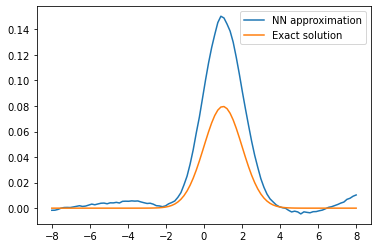

Epoch 6000 with loss 0.004570193123072386


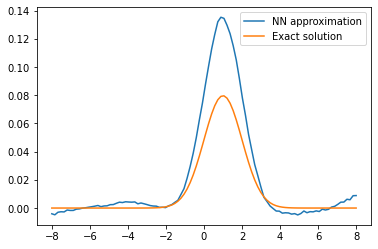

Epoch 6500 with loss 0.0031890536192804575


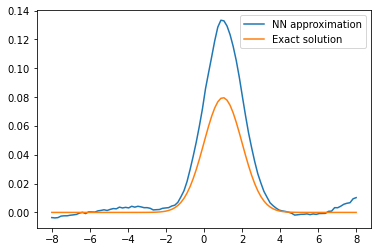

Epoch 7000 with loss 0.0031162668019533157


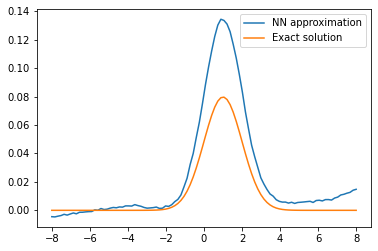

Epoch 7500 with loss 0.003444198053330183


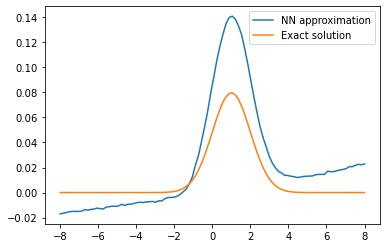

Epoch 8000 with loss 0.0029776906594634056


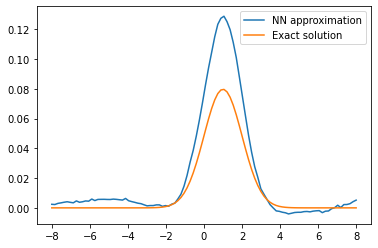

Epoch 8500 with loss 0.0023285788483917713


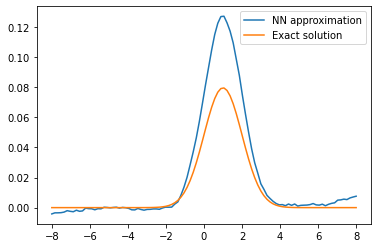

Epoch 9000 with loss 0.0023079304955899715


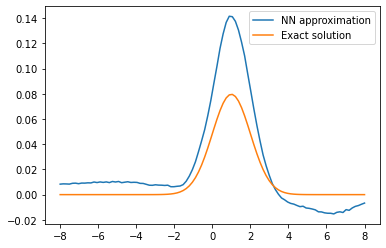

Epoch 9500 with loss 0.003779440186917782


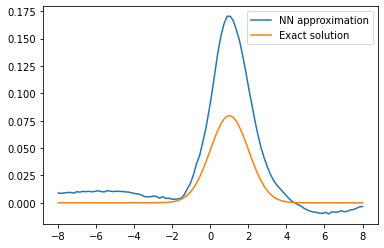

Epoch 9999 with loss 0.004164473153650761
Training of neural network with 10000 epochs take 153.9602403640747 seconds.


In [36]:
model = Net(
    device=device,
    lr_milestones=[5000],
    lr_gamma=1.,
    batch_normalization=False,
    eps=1e-1,
    x_lo=-8, 
    x_hi=8,
)
model.train_and_eval()